## Developing a 'radar wetlands insight tool'

Setup and imports - note dependencies on other DEA scripts

In [2]:
%matplotlib inline
import numpy as np
import datacube
import matplotlib.pyplot as plt
import radar_functions as rf
import radar_gmm as rg
import fiona
from datacube.utils import geometry
import rasterio.features

import xarray as xr

# Import external functions from dea-notebooks
import sys
sys.path.append('./10_Scripts/')
import DEAPlotting, TasseledCapTools, wetlands_insight

In [3]:
#setup radar dc
dc = datacube.Datacube(config='radar.conf')
#optical datacube - the radar one is separate and does not duplicate the Landsat archive
dcO = datacube.Datacube()

In [4]:
#load SAR data
#define the time period
qtime = ('2016-09-01', '2019-06-01')

query = {
         'time': qtime,
         'lat': (-12.70,-12.64),
         'long': (132.53,132.64)
         }

#load the raw SAR scenes
sardata = dc.load(product='s1_gamma0_scene_v2', group_by='solar_day', output_crs='EPSG:3577',resolution=(25,25), **query)

#Denoise and mask the radar data with the actual polygon - it will have been returned as a rectangle
sardata=sardata.where(sardata!=0)
clean=rf.denoise(sardata)
#mask = rasterio.features.geometry_mask([geom.to_crs(sardata.geobox.crs)for geoms in [geom]],
#                                           out_shape=sardata.geobox.shape,
#                                           transform=sardata.geobox.affine,
#                                           all_touched=False,
#                                           invert=False)
#clean=clean.where(~mask)

#drop scenes with a lot of NaN pixels
nanmask = ((np.isnan(clean).mean(dim = ['x','y'])) > 0.2).vv
valtimes = nanmask.where(~nanmask).dropna(dim='time')['time']

clean = clean.sel(time = valtimes)

#'vh_over_vv' channel
clean['vh_over_vv'] = clean.vh/clean.vv

#Take the natural logarithm of the backscatter to improve differentiation of dark areas
logclean = np.log(clean)

In [15]:
wit_arr = wetlands_insight.WIT_array(query)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 31 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 31 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [14]:
import imp
imp.reload(wetlands_insight)

<module 'wetlands_insight' from './10_Scripts/wetlands_insight.py'>

In [11]:
logclean.dims['x']

488

In [48]:
wit_arr.time.data

array(['2016-09-11T01:17:14.000000000', '2016-10-13T01:17:20.000000000',
       '2016-12-16T01:17:16.500000000', '2017-04-23T01:16:23.000000000',
       '2017-05-09T01:16:22.000000000', '2017-05-25T01:16:33.000000000',
       '2017-06-26T01:16:46.000000000', '2017-07-12T01:16:49.000000000',
       '2017-07-28T01:16:56.500000000', '2017-08-29T01:17:06.500000000',
       '2017-09-14T01:17:07.000000000', '2017-10-16T01:17:18.000000000',
       '2018-02-05T01:16:52.000000000', '2018-04-10T01:16:22.500000000',
       '2018-04-26T01:16:13.000000000', '2018-05-28T01:15:51.000000000',
       '2018-06-13T01:15:52.500000000', '2018-06-29T01:16:03.000000000',
       '2018-07-15T01:16:10.500000000', '2018-07-31T01:16:18.000000000',
       '2018-08-16T01:16:27.000000000', '2018-09-01T01:16:34.000000000',
       '2018-09-17T01:16:38.000000000', '2018-10-03T01:16:46.000000000',
       '2018-10-19T01:16:52.000000000', '2018-12-06T01:16:54.500000000',
       '2019-01-07T01:16:52.000000000', '2019-02-24

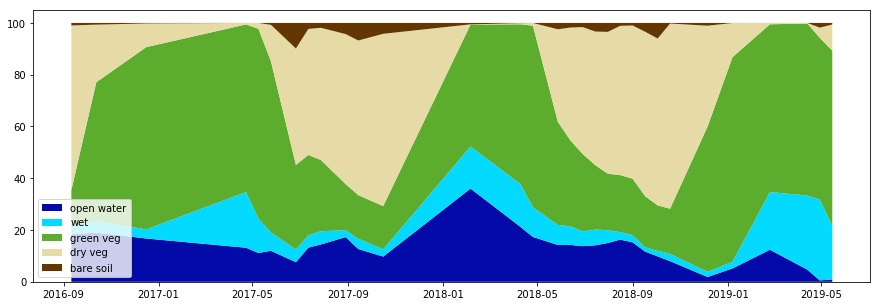

In [56]:
import seaborn as sns

plt.subplots(1,1,figsize=(15,5))

#set up color palette
pal = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]]       

plt.stackplot(wit_arr.time.data,wit_arr.to_array().data,labels=['open water',
                      'wet',
                      'green veg',
                      'dry veg',
                      'bare soil',
                     ], colors=pal)

plt.legend(loc='lower left')

In [29]:
import radar_gmm as rg

In [40]:
kmm = rg.fit_kmeans(logclean.isel(time=-25),n_components=4)

In [ ]:
#multiprocessing routine to speed up the timeseries calculation
import multiprocessing as mp

pool = mp.Pool(mp.cpu_count())

index_stops = np.linspace(0,len(clean.time),num=mp.cpu_count()+1,dtype=int)

results = [pool.apply_async(rg.calc_gmm_timeseries,args=(logclean,kmm),kwds={'tmin':index_stops[i],'tmax':index_stops[i+1]}) for i in range(len(index_stops) - 1)]

pool.close()
pool.join()

res_a = [r.get() for r in results]

t = xr.concat([res[0] for res in res_a],dim='time')
ts = np.concatenate(tuple(res[1] for res in res_a))

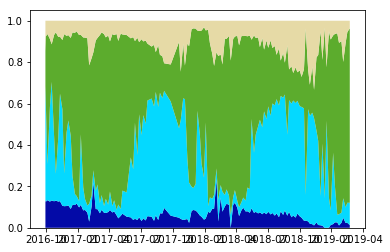

In [61]:
plt.stackplot(t.data,ts.transpose(),colors=pal)

In [62]:
kmm.cluster_centers_

array([[-5.0494337, -6.004362 , -0.9549273],
       [-2.596185 , -4.0509753, -1.454791 ],
       [-1.9442637, -3.3867054, -1.4424436],
       [-3.086841 , -4.821697 , -1.7348541]], dtype=float32)

In [105]:
imp.reload(wetlands_insight)

<module 'wetlands_insight' from './10_Scripts/wetlands_insight.py'>

In [106]:
covclass = wetlands_insight.WIT_da(query)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 31 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 31 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [107]:
covclass

<xarray.DataArray 'maxFC' (time: 31, y: 264, x: 488)>
array([[[3., 3., ..., 4., 4.],
        [3., 3., ..., 4., 4.],
        ...,
        [4., 4., ..., 4., 4.],
        [4., 4., ..., 4., 4.]],

       [[3., 3., ..., 3., 3.],
        [3., 3., ..., 3., 3.],
        ...,
        [4., 4., ..., 3., 3.],
        [4., 4., ..., 3., 3.]],

       ...,

       [[1., 1., ..., 3., 3.],
        [1., 1., ..., 3., 3.],
        ...,
        [3., 3., ..., 3., 3.],
        [3., 3., ..., 3., 3.]],

       [[3., 3., ..., 3., 3.],
        [3., 3., ..., 3., 3.],
        ...,
        [3., 3., ..., 3., 3.],
        [3., 3., ..., 3., 3.]]])
Coordinates:
  * time     (time) datetime64[ns] 2016-09-11T01:17:14 ... 2019-05-15T01:16:35
  * y        (y) float64 -1.334e+06 -1.334e+06 ... -1.34e+06 -1.34e+06
  * x        (x) float64 5.854e+04 5.856e+04 5.859e+04 ... 7.069e+04 7.071e+04

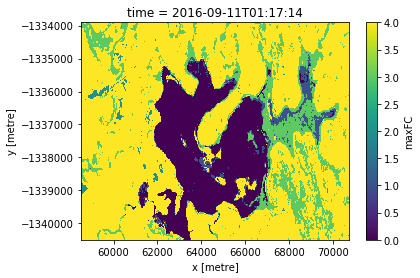

In [108]:
covclass.isel(time=0).plot()